# Tecnologias de Processamento de dados - 2019/2020

## Phase III - Group 12


Student|Student ID|Contribution in hours
-|-|-
Beatriz Lima|49377|                      
David Almeida|54120|<center>8h</center>                  
João Castanheira|55052|                      
Pedro Cotovio|55053|

# 1. OLAP Queries

###  a. Previously defined queries

Check and revise the queries defined in Phase I. Ensure that the queries are meaningful for the processes at hand.

![Bus matrix](images/bus_matrix.png)

Demand queries (relative to the Bookings fact table):
 - The calendar period in which properties are available or not;
 - Locations where the properties are most available;
 - Correlation between host profile and demand for their listings;
 - The types of properties that are most sought after.
 
These queries were defined in Phase I and are still relevant for understanding the demand and the clients behaviour or preferences. We think that it might be interesting to pursue the analysis of the most popular locations in each time of the year.

Supply queries (relative to the Listings fact table):
 - Number of listings by parish or county, and their evolution over time;
 - Use the Review dimension to check in which parishes the listings with high review scores are located;
 - Check price evolution across differents locations;
 - Locations where hosts have listings in comparison to their listed residence (“Are hosts residents in foreign countries?”, “Are they investors from richer countries?”);
 - Analyse the evolution over time and across locations, of types of properties using the Property dimension, providing an overview on what the platform can supply.

### b. For each query type identify dimensions, attributes and measures for each one

- **Query 1**) hottest months/dates and most popular locations.
This analysis involves the date and location dimensions, and the bookings fact table. We will try different grains of detail, going from weeks to months and seasons, etc. The same goes for the location, where the hierarchy of parish and county will be explored through roll up or down operations. We will also try to establish an association with the price per night (bookings fact table measure).


- **Query 2**) locations where hosts have listings in comparison to their listed residence.
This query looks at the ownership of Airbnb-listed properties by extracting information about listings' locations and their respective hosts' locations. It will make use of two dimensions, Location and Host, associated with the Listings fact table. In this way, we can understand how ownership is distributed, that is, if listings are hosted by locals, or by foreigners that have invested in properties abroad.

- **Query 3**)
- **Query 4**)

### c. SQL queries 
Write the SQL queries and execute them. Make sure the results are understandable

In [ ]:
#1. Libraries
import psycopg2 as pg
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
import os

#2. set environment variable for psycog2 (for some systems)
os.environ["PGGSSENCMODE"] = "disable"

#3. get the stored Passwords
f=open("credentials.txt", "rt")
pwd=f.readline().strip()  #di   pass 
hpwd=f.readline().strip() #home pass
f.close()

#4. test connections using the password
conn = pg.connect(host="appserver-01.alunos.di.fc.ul.pt",database="tpd012", user="tpd012", password=pwd)
conn.close()

# local test
#conn = pg.connect(host="localhost",database="teste", user="postgres", password=hpwd)
#conn.close()

#### Query 1 -  hottest months/dates and most popular locations 

#### Query 2 - property ownership characteristics

In [ ]:
query2 = """
DROP VIEW IF EXISTS query2;

CREATE VIEW query2 AS
SELECT
    location.street, location.parish, location.county,
    host.host_country, host.host_continent, host.host_country_gdp, host.membership_duration,
    count(*)
FROM 
	listings,
	location,
	host
WHERE
	location.street LIKE '%' AND
	listings.location_id = location.location_id AND
	listings.host_id = host.host_id
GROUP BY
	location.street, location.parish, location.county,
    host.host_country, host.host_continent, host.membership_duration, host.host_country_gdp
ORDER BY street ASC, count DESC;

SELECT * FROM query2
"""

In [ ]:
conn = pg.connect(host="appserver-01.alunos.di.fc.ul.pt",database="tpd012", user="tpd012", password=pwd)
q2_df = sqlio.read_sql_query(query2, conn)
conn = None

In [ ]:
q2_df.to_csv('q2.csv')
display(q2_df)

In [ ]:
idx = input("Choose property location attribute to cross:")
col = input("Choose host residence attribute to cross:")

q2_pivot = pd.pivot_table(q2_df, values = 'count', index = idx, columns = col, aggfunc = sum, margins = True)
display(q2_pivot)

The motivation behind this query is the business interest in profiling and targetting. Naturally, for a business to expand and succeed, it must identify its target audience and its goal market, so as to intervene in this space and promote its role there. In the business intelligence side, how is it possible to accurately identify who is using a service? This is achieved by analysing customer/client data.

For the Airbnb model, there are two types of targets: customers, a.k.a. tourists, which seek to use Airbnb's platform to book a stay or an experience somewhere, and hosts, which use Airbnb's platform to advertise their properties and services to a broader audience. Both are essential, of course, for this business model to work: they work as demand and supply, respectively, and must coexist in a balanced fashion. Airbnb profits from both: more clients lead to more bookings, which generate direct revenue from the fee Airbnb takes from every listing, and more hosts expands the options Airbnb offers, increasing the likelihood clients will have something to their taste, and increasing the number of revenue sources.

This query seeks to profile hosts in a manner that understands their geo-economical context. This is an important insight to obtain. Customer data would be even more precious for this type of analysis, however, such data is not at our disposal, and as such, we opted for this approach to work as a sort of proof-of-concept.

For this, we extract information about the host's location of residence and cross it with their owned properties' information, in order to understand if there are interesting patterns in property ownership according to host characteristics. The pivot table format makes the interpretation of this data much clearer by crossing fields of interest.

If implemented in a more user-friendly manner, attribute selection for the pivot table would have a more intuitive interface. With the _.csv_ file produced, it's possible to create a data visualisation dashboard that eases interpretation and analysis. For this, we used the software Power BI.

Via Wikidata's SPARQL Query Tool, it's possible to obtain many different kinds of data. Geographical coordinates for Portuguese parishes were extracted from the database using an appropriate query and downloaded as a _.csv_ file. Both _.csv_ were uploaded to Power BI, related by their attribute "Parish", and, in this way, the number of properties in each geographical location can be associated with their place on a map.

Other options, such as importing additional geographical data (for counties, for example, and other countries, if the dataset encompassed more than one country), would also result in interesting visualisations to analyse with distinct levels of granularity.

Below, we can see the resulting dashboard. Each circle is proportional to the number of properties in the corresponding location, and it's sliced in a pie chart to denote which countries the hosts are residents of. Other host characteristics could be selected to define the pie chart.

<img src="DashboardQ2.png" alt="Power BI Query 2 Dashboard" width="1000"/>

# 2. Bottlenecks

###  a. Most important bottlenecks and performance analysis
Identify the most important bottlenecks and execute performance analysis

#### Query 2

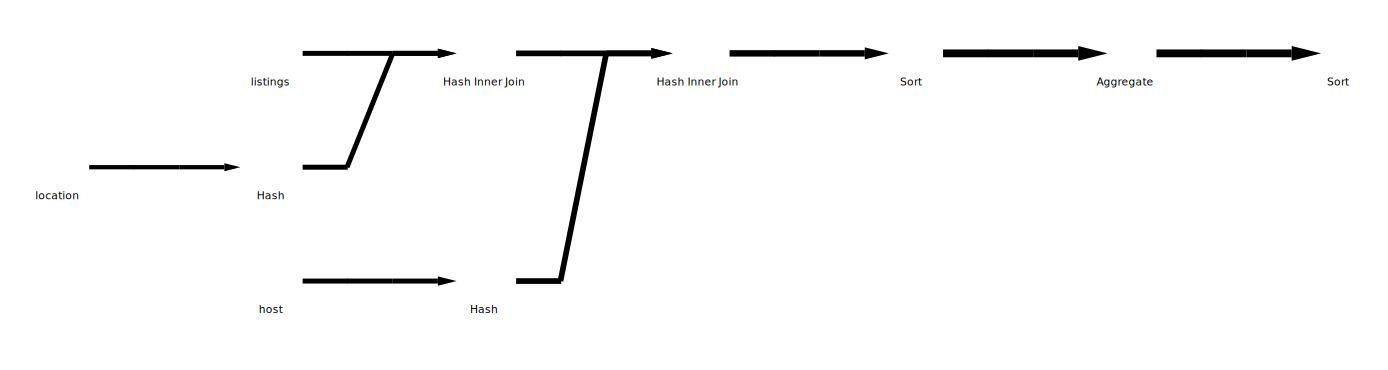

In [2]:
from IPython.display import SVG
SVG(filename='q2_plan1.svg')

### b. Plan for improving performance

#### Query 2
This query already works with significant speed. However, a materialized view is a candidate to reduce computation time for this query. In this way, every time the query was run, only the view table would need to be consulted, and all aggregations and sortings would have been done already. But a materialized view benefits most the cases where queries are run often and updates aren't constant, because in this way, the view table available is already pre-computed with all the necessary data.

Overall, this query wouldn't be one to run very frequently. After all, property ownership trends and patterns are expected to change over many years, and any effort by Airbnb to influence this would only be possible to analyse after a significant amount of time. As such, its computational efficiency isn't an urgent necessity for the business process.

Implementing a materialized view (given that the appserver's PostgreSQL version does not support this, a new equivalent data table was created), the querying of data becomes a simple subsetting of the table columns and the query is reduced to a quick sequential scan.

### c. Verify that the proposed modifications have better performance

#### Query 2

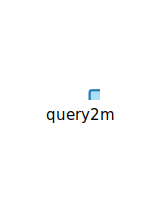

In [3]:
SVG(filename='q2_plan2.svg')

### d. Discussion

With the full use of the data warehouse what are the expectation for its growth in 1, 5 and 10 years. Identify what approaches would be used to address such an increase in data

# 3. Critical assessment

###  a. Phases comparison
For each of the 3 phases of the project discuss what went right, wrong and what would you do to make it better?

In Phase II, each ETL process could have been optimised to perform better, as well as have cleaner code. For example, some ETL pipelines for certain dimensions were designed in such a way as to allow for constant reuse of the code without redundant calculations (it works for either first insert of the data/dimension construction, or for any subsequent data insertions), whereas other pipelines were divided into dimension construction/first data insertion + subsequent data insertions.

Overall, the chosen dataset has its limitations in the ways we can model the data. This is mainly due to the fact that it is a product of web scraping and, as such, important information for business intelligence is unattainable. Certain initial plans had to be changed. However, it also allowed us to explore particular cases of data warehouse design and dimension modelling, such as the factless fact table Bookings.

### b. Grade proposal
For each phase propose a grade (1-20). Justify your grade.

